# Open and analyse JM synthesis

In [47]:
%matplotlib notebook

import numpy as np
import healpy as hp
from matplotlib import pyplot as plt
import glob
from importlib import reload
import pynkowski as mf   # For Minkowski Functionals

import scatcovjax.Sphere_lib as sphlib
from scatcovjax.Scattering_lib import scat_cov_axi, scat_cov_dir
from s2wav.filter_factory.filters import filters_directional_vectorised
import scatcovjax.Scattering_lib as scatlib

import s2fft
import s2wav
import scatcovjax.plotting as plot

plot.notebook_plot_format()

## Load the healpix maps

<IPython.core.display.Javascript object>


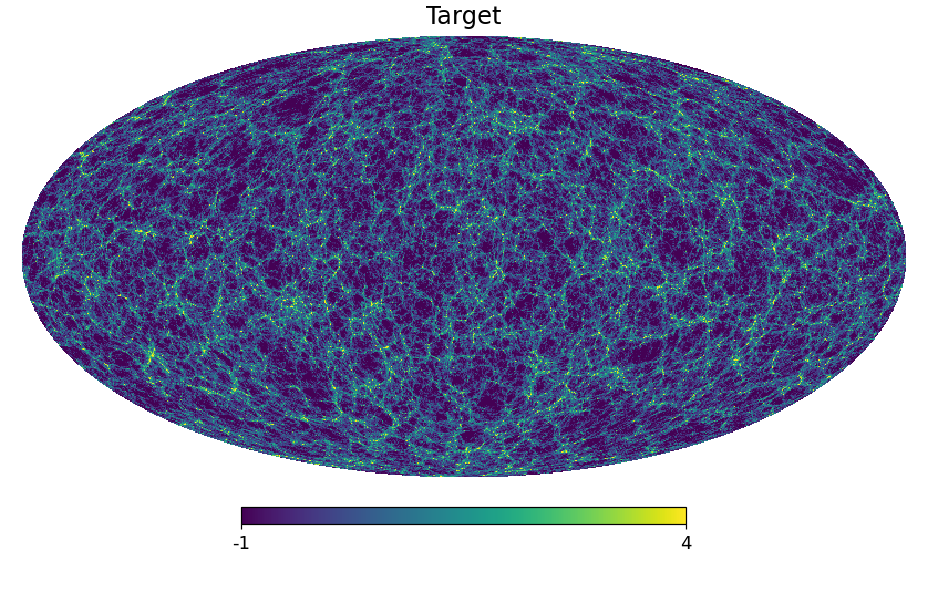

In [48]:
nside = 256

### Target
#f_target = np.load(f'/travail/lmousset/Cosmogrid_Hpx_map_nside{nside}_run0_idx10.npy')
f_target = np.load(f'/travail/jdelouis/target_map_{nside}.npy')
f_target = hp.reorder(f_target, n2r=True) # Convert from nest to ring

hp.mollview(f_target, min=-1, max=4, title='Target')

10 ['/travail/jdelouis/synthe_N012_256.npy', '/travail/jdelouis/synthe_N015_256.npy', '/travail/jdelouis/synthe_N014_256.npy', '/travail/jdelouis/synthe_N019_256.npy', '/travail/jdelouis/synthe_N018_256.npy', '/travail/jdelouis/synthe_N011_256.npy', '/travail/jdelouis/synthe_N016_256.npy', '/travail/jdelouis/synthe_N017_256.npy', '/travail/jdelouis/synthe_N010_256.npy', '/travail/jdelouis/synthe_N013_256.npy']
N012


<IPython.core.display.Javascript object>


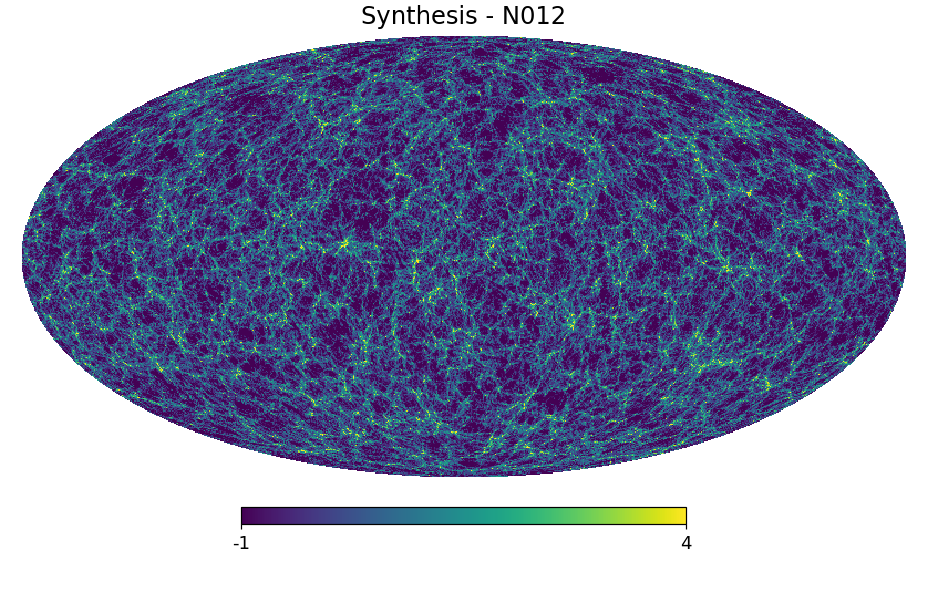

In [49]:
### Synthesis
real = 0
#f_end_list = glob.glob(f'/travail/jdelouis/synthe_S*_{nside}.npy')
f_end_list = glob.glob(f'/travail/jdelouis/synthe_N*_{nside}.npy')
nreals = len(f_end_list)
print(nreals, f_end_list)
f_end = np.load(f_end_list[real])
f_end = hp.reorder(f_end, n2r=True) # Convert from nest to ring

name = f_end_list[real][25:29] ### Name given by JM
print(name)
hp.mollview(f_end, min=-1, max=4, title=f'Synthesis - {name}')

# Histogram

<IPython.core.display.Javascript object>


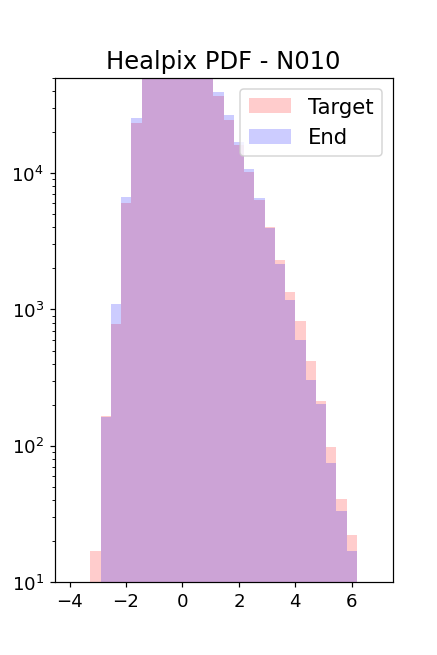

In [50]:
### Do it for one real
r = 8
## Get the map
#f_end_list = glob.glob(f'/travail/jdelouis/synthe_S*_{nside}.npy')
f_end_list = glob.glob(f'/travail/jdelouis/synthe_N*_{nside}.npy')
name = f_end_list[r][25:29] ### Name given by JM
f_end = np.load(f_end_list[r])
f_end = hp.reorder(f_end, n2r=True) # Convert from nest to ring

## Plot the histogram
fig, ax0 = plt.subplots(1, 1, figsize=(4, 6))

ax0.hist(f_target, bins=30, range=(f_target.min(), f_target.max()), 
         density=False, color='r', alpha=0.2, label='Target')
ax0.hist(f_end, bins=30, range=(f_target.min(), f_target.max()), 
         density=False, color='b', alpha=0.2, label='End')
#ax0.hist(f_start_hpx, bins=30, density=True, color='g', alpha=0.2, label='Start')
ax0.set_title(f'Healpix PDF - {name}')
ax0.set_yscale("log")
ax0.set_ylim(10, 5e4)
ax0.legend()

## Skewness and kurtosis

In [51]:
def skewness(X):
    mu = np.mean(X)
    std = np.std(X)
    return np.mean(((X-mu) / std)**3)

def kurtosis(X):
    mu = np.mean(X)
    std = np.std(X)
    return np.mean(((X-mu) / std)**4)


In [52]:
tskew = skewness(f_target)
tkurt = kurtosis(f_target)

all_eskew, all_ekurt = np.zeros(nreals), np.zeros(nreals)
for r in range(nreals):
    ## Get the map
    #f_end_list = glob.glob(f'/travail/jdelouis/synthe_S*_{nside}.npy')
    f_end_list = glob.glob(f'/travail/jdelouis/synthe_N*_{nside}.npy')
    name = f_end_list[r][25:29] ### Name given by JM

    f_end = np.load(f_end_list[r])
    f_end = hp.reorder(f_end, n2r=True) # Convert from nest to ring
    
    all_eskew[r] = skewness(f_end)
    all_ekurt[r] = kurtosis(f_end)

print(tskew, np.mean(all_eskew), np.std(all_eskew))
print(tkurt, np.mean(all_ekurt), np.std(all_ekurt))

0.902466649242788 0.8075555137621052 0.00246175547895226
4.347736233832389 4.0064424887758845 0.023465137942994284


## Minkowski

In [53]:
def make_minkowski(us, map_hpx):

    data = mf.Healpix(map_hpx, normalise=True, mask=None)     # Default parameters
    v0 = mf.V0(data, us)
    v1 = mf.V1(data, us)
    v2 = mf.V2(data, us)
    
    return v0, v1, v2

In [54]:
us = np.arange(-5., 7.01, 0.1)

v0_target, v1_target, v2_target = make_minkowski(us, f_target)


all_ev0, all_ev1, all_ev2 = np.zeros((nreals, us.size)), np.zeros((nreals, us.size)), np.zeros((nreals, us.size))
for r in range(nreals):
    ## Get the map
    #f_end_list = glob.glob(f'/travail/jdelouis/synthe_S*_{nside}.npy')
    f_end_list = glob.glob(f'/travail/jdelouis/synthe_N*_{nside}.npy')
    name = f_end_list[r][25:29] ### Name given by JM

    f_end = np.load(f_end_list[r])
    f_end = hp.reorder(f_end, n2r=True) # Convert from nest to ring
    
    all_ev0[r, :], all_ev1[r, :], all_ev2[r, :] = make_minkowski(us, f_end)

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

In [55]:
mean_v0 = np.mean(all_ev0, axis=0)
mean_v1 = np.mean(all_ev1, axis=0)
mean_v2 = np.mean(all_ev2, axis=0)

std_v0 = np.std(all_ev0, axis=0)
std_v1 = np.std(all_ev1, axis=0)
std_v2 = np.std(all_ev2, axis=0)

<IPython.core.display.Javascript object>


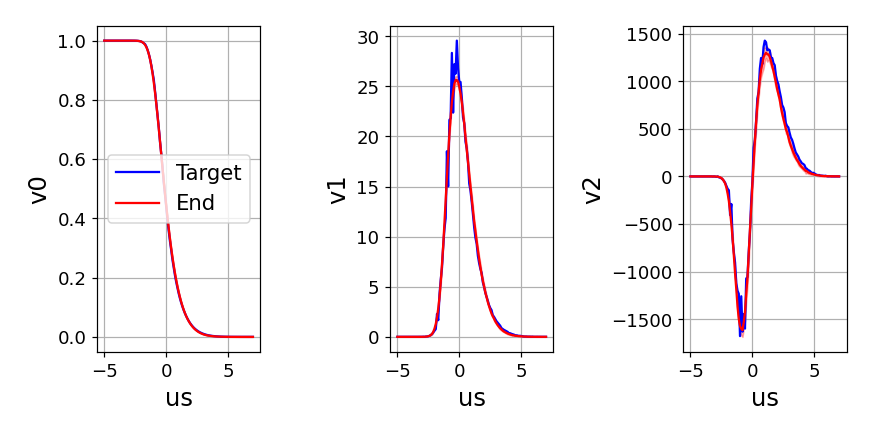

In [56]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(8, 4))

ax0.plot(us, v0_target, color='b', label='Target')
ax0.plot(us, mean_v0, color='r', label='End')
ax0.fill_between(us, mean_v0 - 3*std_v0, mean_v0 + 3*std_v0, color='r', alpha=0.3)
ax0.set_xlabel('us')
ax0.set_ylabel('v0')
ax0.grid()
ax0.legend()

ax1.plot(us, v1_target, color='b', label='Target')
ax1.plot(us, mean_v1, color='r', label='End')
ax1.fill_between(us, mean_v1 - 3*std_v1, mean_v1 + 3*std_v1, color='r', alpha=0.3)
ax1.set_xlabel('us')
ax1.set_ylabel('v1')
ax1.grid()
#ax1.legend()

ax2.plot(us, v2_target, color='b', label='Target')
ax2.plot(us, mean_v2, color='r', label='End')
ax2.fill_between(us, mean_v2 - 3*std_v2, mean_v2 + 3*std_v2, color='r', alpha=0.3)
ax2.set_xlabel('us')
ax2.set_ylabel('v2')
ax2.grid()
#ax2.legend()

fig.tight_layout()

<IPython.core.display.Javascript object>


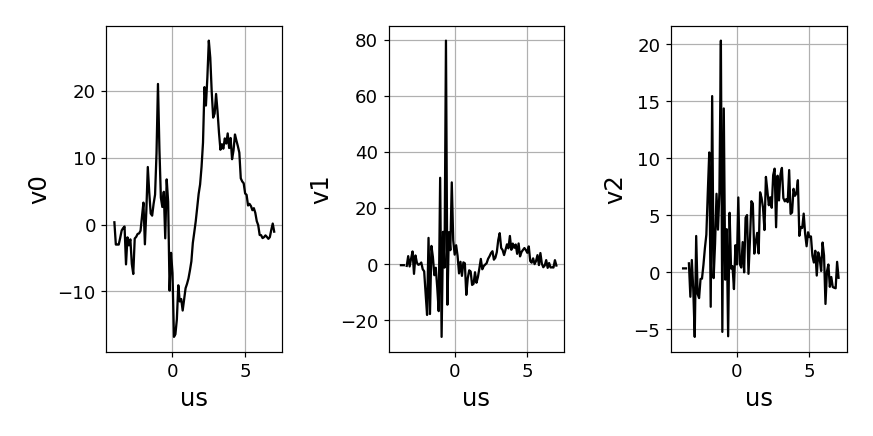

In [57]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(8, 4))

ax0.plot(us, (v0_target - mean_v0)/std_v0, color='k')
ax0.set_xlabel('us')
ax0.set_ylabel('v0')
ax0.grid()

ax1.plot(us, (v1_target - mean_v1)/std_v1, color='k')
ax1.set_xlabel('us')
ax1.set_ylabel('v1')
ax1.grid()

ax2.plot(us, (v2_target - mean_v2)/std_v2, color='k')
ax2.set_xlabel('us')
ax2.set_ylabel('v2')
ax2.grid()

fig.tight_layout()

## Power spectrum

In [58]:
## Target
flm_target = s2fft.forward_jax(f_target, L=2*nside, nside=nside, sampling='healpix', reality=False)
print(flm_target.shape)
ps_target = sphlib.compute_ps(flm_target)

all_ps = np.zeros((nreals, ps_target.size))
for r in range(nreals):
    ## Get the map
    #f_end_list = glob.glob(f'/travail/jdelouis/synthe_S*_{nside}.npy')
    f_end_list = glob.glob(f'/travail/jdelouis/synthe_N*_{nside}.npy')
    name = f_end_list[r][25:29] ### Name given by JM

    f_end = np.load(f_end_list[r])
    f_end = hp.reorder(f_end, n2r=True) # Convert from nest to ring
    flm_end = s2fft.forward_jax(f_end, L=2*nside, nside=nside, sampling='healpix', reality=False)

    all_ps[r, :] = sphlib.compute_ps(flm_end)

mean_ps = np.mean(all_ps, axis=0)
std_ps = np.std(all_ps, axis=0)

(512, 1023)


<IPython.core.display.Javascript object>


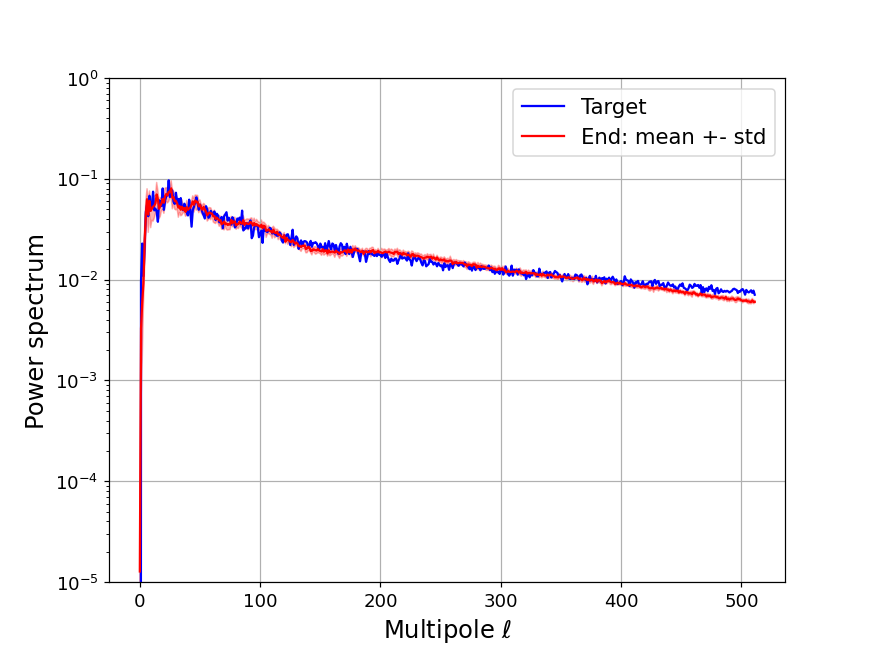

In [59]:
xx = np.arange(2*nside)

plt.figure(figsize=(8, 6))
plt.plot(xx, ps_target, 'b', label="Target")
plt.plot(xx, mean_ps, 'r', label="End: mean +- std")
plt.fill_between(xx, mean_ps - std_ps, mean_ps + std_ps, color='r', alpha=0.3)
plt.yscale("log")
#plt.xscale("log", base=2)
plt.xlabel(r'Multipole $\ell$')
plt.ylabel('Power spectrum')
plt.grid()
#plt.xlim(2, 256)
plt.ylim(1e-5, 1)
plt.legend()

## Scatterings coefficients

In [60]:
sampling = "mw"
multiresolution = True
reality = False

L = 2*nside
N = 2
J_min = 2

J_max = s2wav.utils.shapes.j_max(L)
J = J_max - J_min + 1
print(f'{J=} {J_max=}')


J=8 J_max=9


<IPython.core.display.Javascript object>


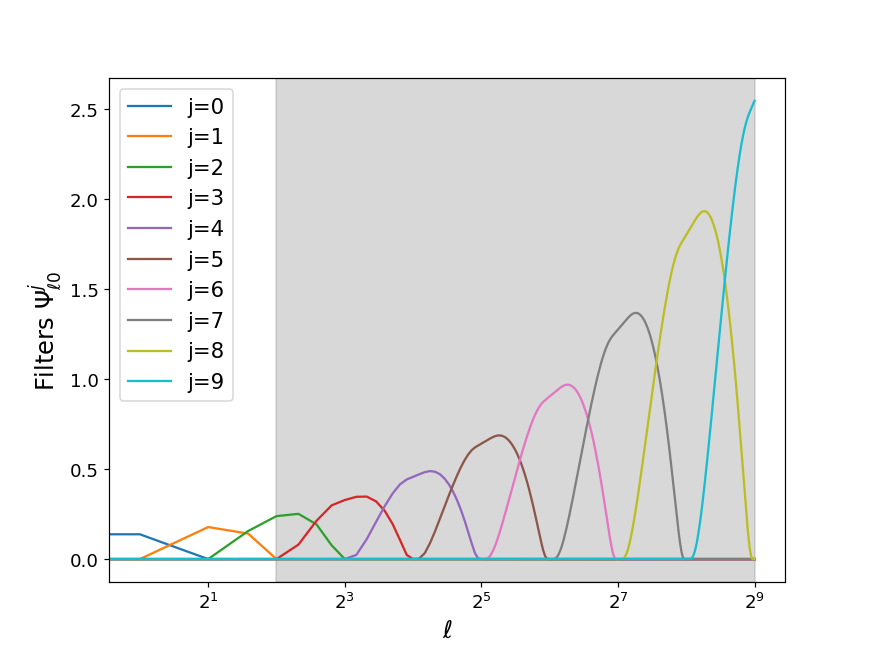

In [61]:
filters = filters_directional_vectorised(L, N, J_min)
plot.plot_filters(filters, real=False, m=L-2)
plt.axvspan(2**J_min, 2**J_max, color='grey', alpha=0.3)

# Take the wavelets only, not the scaling function
filters = filters[0]  

In [62]:

weights = scatlib.quadrature(L, J_min, sampling, None, multiresolution)

precomps = s2wav.transforms.jax_wavelets.generate_wigner_precomputes(L, N, J_min, 2.0, sampling, None, False,
                                                                     reality, multiresolution)

In [63]:
### Scat coeffs S1, P00, C01, C11
## Target
tcoeffs = scatlib.scat_cov_dir(flm_target, L, N, J_min, sampling, None,
                       reality, multiresolution, for_synthesis=True, normalisation=None,
                       filters=filters, quads=weights, precomps=precomps)

tmean, tvar, tS1, tP00, tC01, tC11 = tcoeffs  # 1D arrays

## Synthesis
all_eS1, all_eP00 = np.zeros((nreals, tS1.size)), np.zeros((nreals, tP00.size))
all_eC01, all_eC11 = np.zeros((nreals, tC01.size)), np.zeros((nreals, tC11.size))
for r in range(nreals):
    ## Get the map
    #f_end_list = glob.glob(f'/travail/jdelouis/synthe_S*_{nside}.npy')
    f_end_list = glob.glob(f'/travail/jdelouis/synthe_N*_{nside}.npy')
    name = f_end_list[r][25:29] ### Name given by JM
    f_end = np.load(f_end_list[r])
    f_end = hp.reorder(f_end, n2r=True) # Convert from nest to ring
    
    ## Get the flm
    flm_end = s2fft.forward_jax(f_end, L=2*nside, nside=nside, sampling='healpix', reality=False)

    
    ecoeffs = scatlib.scat_cov_dir(flm_end, L, N, J_min, sampling, None,
                       reality, multiresolution, for_synthesis=True, normalisation=None,
                       filters=filters, quads=weights, precomps=precomps)

    emean, evar, all_eS1[r, :], all_eP00[r, :], all_eC01[r, :], all_eC11[r, :] = ecoeffs  # 1D arrays


 j2=2 Lj2=8

 j2=3 Lj2=16

 j2=4 Lj2=32

 j2=5 Lj2=64

 j2=6 Lj2=128

 j2=7 Lj2=256

 j2=8 Lj2=512

 j2=9 Lj2=512


In [64]:
mean_S1 = np.mean(all_eS1, axis=0)
mean_P00 = np.mean(all_eP00, axis=0)
mean_C01 = np.mean(all_eC01, axis=0)
mean_C11 = np.mean(all_eC11, axis=0)

std_S1 = np.std(all_eS1, axis=0)
std_P00 = np.std(all_eP00, axis=0)
std_C01 = np.std(all_eC01, axis=0)
std_C11 = np.std(all_eC11, axis=0)

<IPython.core.display.Javascript object>


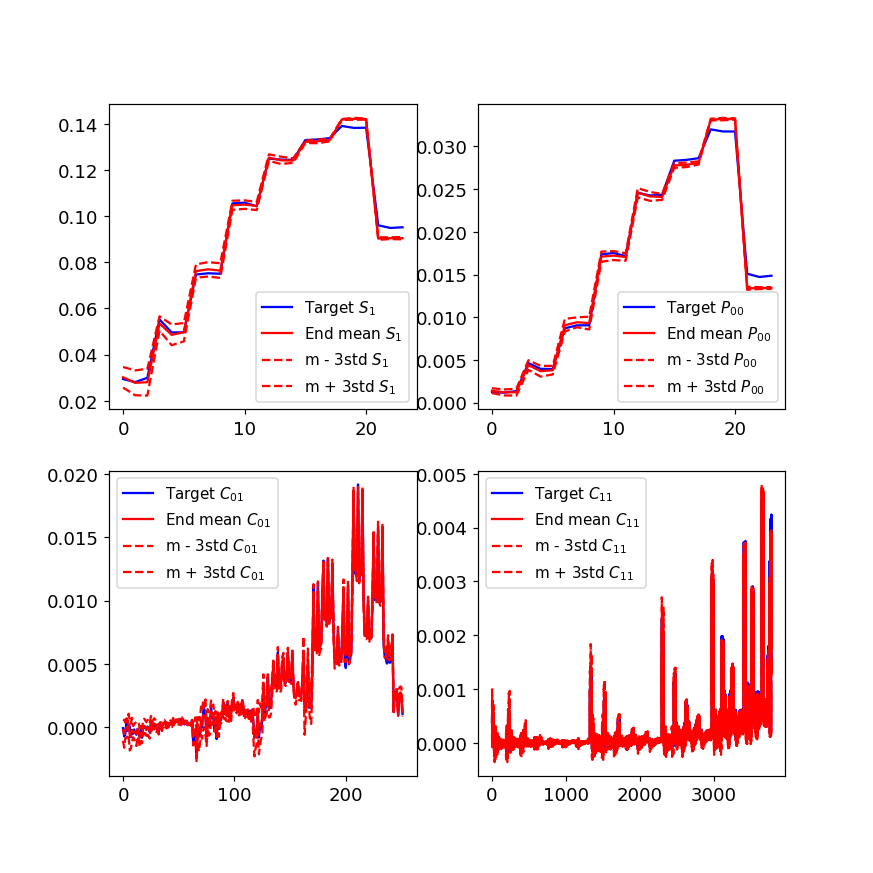

In [65]:
plt.rc('legend', fontsize=10)  # legend fontsize

plot.plot_scatcov_coeffs(tS1, tP00, tC01, tC11, name='Target', hold=True, color='blue')

plot.plot_scatcov_coeffs(mean_S1, mean_P00, mean_C01, mean_C11, name='End mean', hold=False, color='red')
plot.plot_scatcov_coeffs(mean_S1-3*std_S1, mean_P00-3*std_P00, mean_C01-3*std_C01, mean_C11-3*std_C11, 
                         name='m - 3std', hold=False, color='red', ls='--')
plot.plot_scatcov_coeffs(mean_S1+3*std_S1, mean_P00+3*std_P00, mean_C01+3*std_C01, mean_C11+3*std_C11, 
                         name='m + 3std', hold=False, color='red', ls='--')
